In [75]:
# import libraries

import geopandas as gpd
import fiona
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterstats import zonal_stats
import richdem as rd
from shapely.geometry import Point

In [76]:
# Load the shelter and grid datasets
shelters = pd.read_csv("shelter_data.csv")
grid = pd.read_csv("grid.csv")

# Clean union column
shelters["union"] = shelters["union"].str.lower().str.strip()

# Rename teknaf sadar to teknaf
shelters["union"] = shelters["union"].replace({
    "teknaf sadar": "teknaf"
})

shelters = shelters[['CS_ID', 'District', 'Upazila', 'union', 'lon', 'lat',
       'Shelter Name (English)', 'DRRO Capacity']]

# Show the first few rows
shelters.head()

,CS_ID,District,Upazila,union,lon,lat,Shelter Name (English),DRRO Capacity
0,cs_1,cox's bazar,teknaf,teknaf paurashava,92.290678,20.856927,baitus saraf muhammodia riadul jannah dakil ma...,1000.0
1,cs_10,cox's bazar,teknaf,sabrang,92.332180,20.760671,sahaporirdip dakkin para center,1000.0
2,cs_100,cox's bazar,ukhiya,palong khali,92.168040,21.189026,balokhali govt. primary school,400.0
3,cs_101,cox's bazar,ukhiya,palong khali,92.168101,21.190423,balukhali kamenia high school,250.0
4,cs_102,cox's bazar,ukhia,palong khali,92.169807,21.144842,farir beel alim madrasha,2500.0


In [77]:
# import union boundary data
path = "gadm41_BGD.gpkg"

# Show layers
print(fiona.listlayers(path))

# Load the union (ADM4) layer
gdf = gpd.read_file(path, layer="ADM_ADM_4")

gdf.head(), gdf.columns

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2', 'ADM_ADM_3', 'ADM_ADM_4']


(           GID_4 GID_0     COUNTRY    GID_1   NAME_1      GID_2   NAME_2  \
 0  BGD.1.1.1.1_1   BGD  Bangladesh  BGD.1_1  Barisal  BGD.1.1_1  Barguna   
 1  BGD.1.1.1.2_1   BGD  Bangladesh  BGD.1_1  Barisal  BGD.1.1_1  Barguna   
 2  BGD.1.1.1.3_1   BGD  Bangladesh  BGD.1_1  Barisal  BGD.1.1_1  Barguna   
 3  BGD.1.1.1.4_1   BGD  Bangladesh  BGD.1_1  Barisal  BGD.1.1_1  Barguna   
 4  BGD.1.1.1.5_1   BGD  Bangladesh  BGD.1_1  Barisal  BGD.1.1_1  Barguna   
 
          GID_3  NAME_3        NAME_4 VARNAME_4 TYPE_4 ENGTYPE_4      CC_4  \
 0  BGD.1.1.1_1  Amtali        Amtali        NA  Union     Union  10040913   
 1  BGD.1.1.1_1  Amtali   Arpangashia        NA  Union     Union  10040915   
 2  BGD.1.1.1_1  Amtali  Atharagashia        NA  Union     Union  10040923   
 3  BGD.1.1.1_1  Amtali      Barabagi        NA  Union     Union  10040939   
 4  BGD.1.1.1_1  Amtali   Chhota Bagi        NA  Union     Union  10040943   
 
                                             geometry  
 0  MULTIP

In [78]:
# filter 12 mainland unions

mainland_unions = [
    # Teknaf mainland (7)
    "Teknaf", "Teknaf Paurashava",
    "Sabrang", "Baharchhara", "Whykong", "Nhilla",
    # Ukhiya mainland (5)
    "Palong Khali", "Jalia Palong", "Haldia Palong",
    "Ratna Palong", "Raja Palong"
]

gdf_mainland = gdf[gdf["NAME_4"].isin(mainland_unions)]

gdf_mainland

,GID_4,GID_0,COUNTRY,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,geometry
646,BGD.2.4.3.1_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.4_1,Chittagong,BGD.2.4.3_1,Banshkhali,Baharchhara,NA,Union,Union,20150811,"MULTIPOLYGON (((91.87666 22.04569, 91.87646 22..."
1150,BGD.2.6.7.1_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Baharchhara,NA,Union,Union,20229015,"MULTIPOLYGON (((92.2329 20.9046, 92.23286 20.9..."
1151,BGD.2.6.7.2_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Nhilla,NA,Union,Union,20229031,"MULTIPOLYGON (((92.22903 21.10732, 92.2335 21...."
1152,BGD.2.6.7.3_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Sabrang,NA,Union,Union,20229047,"MULTIPOLYGON (((92.33343 20.83142, 92.33569 20..."
1153,BGD.2.6.7.4_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Teknaf,NA,Union,Union,20229063,"MULTIPOLYGON (((92.2329 20.9046, 92.23347 20.9..."
1154,BGD.2.6.7.5_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Teknaf Paurashava,NA,Union,Union,20229099,"MULTIPOLYGON (((92.32485 20.85797, 92.32455 20..."
1155,BGD.2.6.7.6_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Whykong,NA,Union,Union,20229079,"MULTIPOLYGON (((92.18731 21.01805, 92.18723 21..."
1156,BGD.2.6.8.1_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.8_1,Ukhia,Haldia Palong,NA,Union,Union,20229415,"MULTIPOLYGON (((92.14312 21.34876, 92.14346 21..."
1157,BGD.2.6.8.2_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.8_1,Ukhia,Jalia Palong,NA,Union,Union,20229431,"MULTIPOLYGON (((92.13313 21.08078, 92.13338 21..."
1158,BGD.2.6.8.3_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.8_1,Ukhia,Palong Khali,NA,Union,Union,20229479,"MULTIPOLYGON (((92.16824 21.21324, 92.16821 21..."


In [79]:
# filter to cox's bazar unions

cox = gdf_mainland[gdf_mainland["NAME_2"].str.lower() == "cox's bazar"]

cox.head()

,GID_4,GID_0,COUNTRY,GID_1,NAME_1,GID_2,NAME_2,GID_3,NAME_3,NAME_4,VARNAME_4,TYPE_4,ENGTYPE_4,CC_4,geometry
1150,BGD.2.6.7.1_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Baharchhara,NA,Union,Union,20229015,"MULTIPOLYGON (((92.2329 20.9046, 92.23286 20.9..."
1151,BGD.2.6.7.2_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Nhilla,NA,Union,Union,20229031,"MULTIPOLYGON (((92.22903 21.10732, 92.2335 21...."
1152,BGD.2.6.7.3_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Sabrang,NA,Union,Union,20229047,"MULTIPOLYGON (((92.33343 20.83142, 92.33569 20..."
1153,BGD.2.6.7.4_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Teknaf,NA,Union,Union,20229063,"MULTIPOLYGON (((92.2329 20.9046, 92.23347 20.9..."
1154,BGD.2.6.7.5_1,BGD,Bangladesh,BGD.2_1,Chittagong,BGD.2.6_1,Cox'S Bazar,BGD.2.6.7_1,Teknaf,Teknaf Paurashava,NA,Union,Union,20229099,"MULTIPOLYGON (((92.32485 20.85797, 92.32455 20..."


In [80]:
# Clean union names
shelter_unions = (
    shelters["union"]
    .dropna()
    .str.lower()
    .str.strip()
    .unique()
)

adm4_unions = (
    cox["NAME_4"]
    .dropna()
    .str.lower()
    .str.strip()
    .unique()
)

# Convert to sets
shelter_set = set(shelter_unions)
adm4_set = set(adm4_unions)

print("\nShelter unions:", shelter_set)
print("\nADM4 unions:", adm4_set)

print("\nUnions in shelters but NOT in ADM4:")
print(sorted(shelter_set - adm4_set))

print("\nUnions in ADM4 but NOT in shelters:")
print(sorted(adm4_set - shelter_set))

print("\nUnions in BOTH:")
print(sorted(shelter_set & adm4_set))



Shelter unions: {'raja palong', 'whykong', 'haldia palong', 'jalia palong', 'palong khali', 'sabrang', 'ratna palong', 'nhilla', 'teknaf paurashava', 'teknaf', 'baharchhara'}

ADM4 unions: {'raja palong', 'whykong', 'haldia palong', 'jalia palong', 'palong khali', 'sabrang', 'ratna palong', 'nhilla', 'teknaf paurashava', 'teknaf', 'baharchhara'}

Unions in shelters but NOT in ADM4:
[]

Unions in ADM4 but NOT in shelters:
[]

Unions in BOTH:
['baharchhara', 'haldia palong', 'jalia palong', 'nhilla', 'palong khali', 'raja palong', 'ratna palong', 'sabrang', 'teknaf', 'teknaf paurashava', 'whykong']


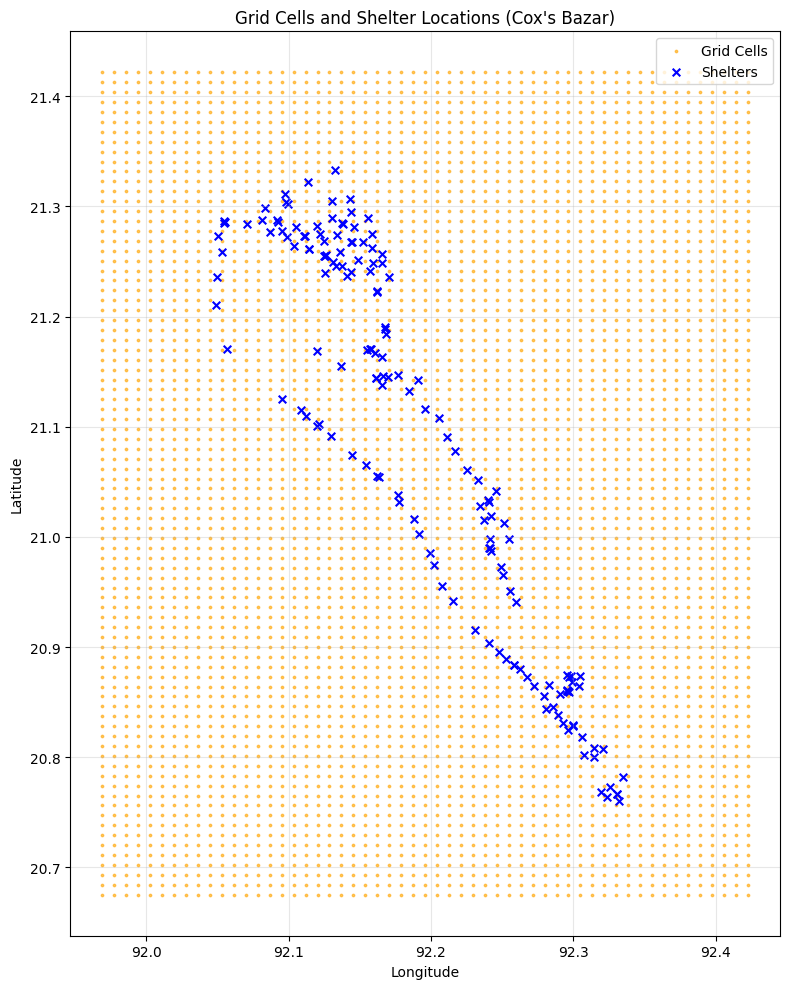

In [81]:
# plot large grid with all shelters

plt.figure(figsize=(8, 10))

# Plot grid cells (small dots)
plt.scatter(
    grid["lon_center"], 
    grid["lat_center"], 
    s=3, 
    color="orange",
    alpha=0.6,
    label="Grid Cells"
)

# Plot shelter locations (larger X markers)
plt.scatter(
    shelters["lon"], 
    shelters["lat"], 
    s=30, 
    color="blue", 
    marker="x", 
    label="Shelters"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid Cells and Shelter Locations (Cox's Bazar)")
plt.legend()

plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

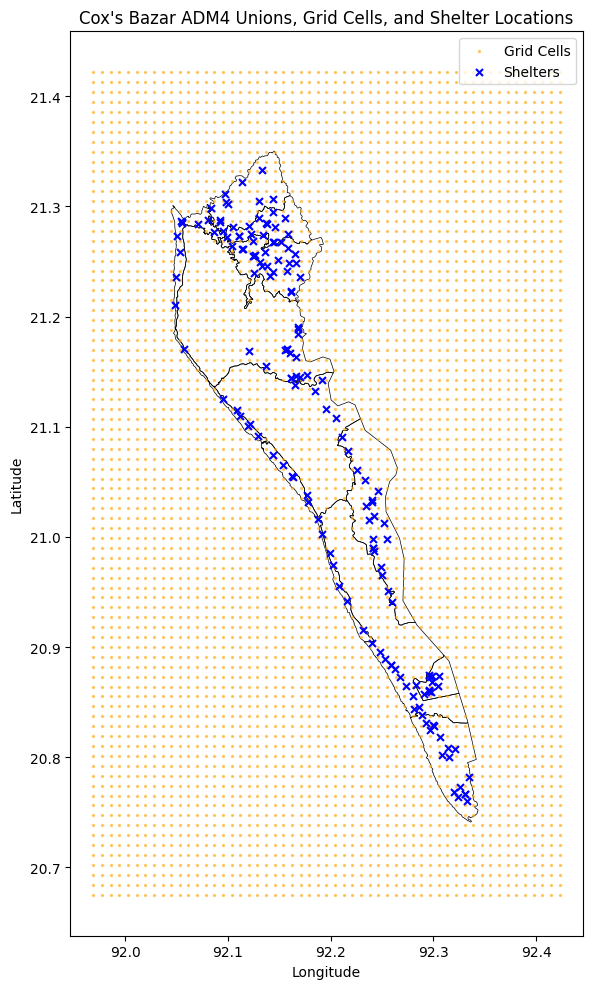

In [82]:
# plot the grid with all the union boundaries  for cox's bazar

# Convert grid to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    grid,
    geometry=gpd.points_from_xy(grid.lon_center, grid.lat_center),
    crs="EPSG:4326",
)

# Plot map
fig, ax = plt.subplots(figsize=(8, 10))

# Plot union boundaries
cox.plot(
    ax=ax,
    facecolor="none",
    edgecolor="black",
    linewidth=0.5
)

# Plot grids
grid_gdf.plot(
    ax=ax,
    color="orange",
    markersize=2,
    alpha=0.5,
    label="Grid Cells"
)

# Plot shelters
plt.scatter(
    shelters["lon"],
    shelters["lat"],
    s=25,
    color="blue",
    marker="x",
    label="Shelters"
)

plt.title("Cox's Bazar ADM4 Unions, Grid Cells, and Shelter Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# Clip grid to only the union polygons

# Convert grid to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    grid,
    geometry=gpd.points_from_xy(grid.lon_center, grid.lat_center),
    crs="EPSG:4326"
)

# Only keep grid cells that fall inside Cox’s Bazar ADM4 boundaries
grid_clipped = gpd.sjoin(
    grid_gdf,
    cox[["NAME_4", "geometry"]],
    how="inner",
    predicate="within"
)

# Rename the joined column for clarity
grid_clipped = grid_clipped.rename(columns={"NAME_4": "union"})

# Drop spatial join index column
grid_clipped = grid_clipped.drop(columns=["index_right"])

print("Original grid size:", len(grid_gdf))
print("Clipped grid size:", len(grid_clipped))

grid_clipped.head()

Original grid size: 4620
Clipped grid size: 671


,lat_center,lon_center,lat_bin,lon_bin,grid_id,geometry,union
483,20.747182,92.330256,9,44,9_44,POINT (92.33026 20.74718),Sabrang
484,20.747182,92.338651,9,45,9_45,POINT (92.33865 20.74718),Sabrang
537,20.756175,92.321860,10,43,10_43,POINT (92.32186 20.75617),Sabrang
538,20.756175,92.330256,10,44,10_44,POINT (92.33026 20.75617),Sabrang
539,20.756175,92.338651,10,45,10_45,POINT (92.33865 20.75617),Sabrang


<Figure size 800x1000 with 0 Axes>

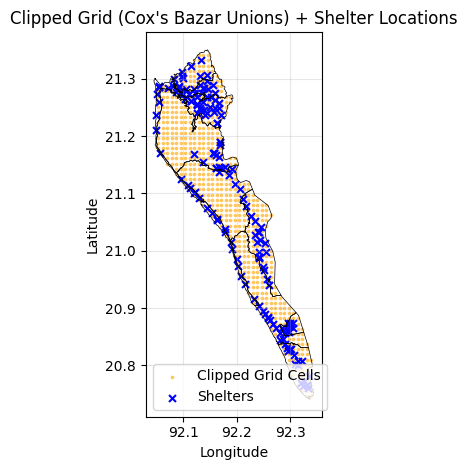

In [84]:
# Plot clipped grid for only cox's bazar 

plt.figure(figsize=(8, 10))

grid_clipped.plot(
    markersize=3, color="orange", alpha=0.5, label="Clipped Grid Cells"
)

# Plot shelters
plt.scatter(
    shelters["lon"], shelters["lat"],
    s=25, color="blue", marker="x", label="Shelters"
)

# Overlay union boundaries
cox.boundary.plot(ax=plt.gca(), linewidth=0.5, color="black")

plt.title("Clipped Grid (Cox's Bazar Unions) + Shelter Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [85]:
# load terrain data

src = rasterio.open("ESA_WorldCover_10m_2021_v200_N21E090_Map.tif")

# Sample raster values at each grid centroid

coords = [(geom.x, geom.y) for geom in grid_clipped.geometry]

# Extract raster land cover class for each grid centroid
landcover_vals = [int(v[0]) for v in src.sample(coords)]

grid_clipped["landcover"] = landcover_vals

# Remove water and ice/snow
grid_cleaned = grid_clipped[grid_clipped["landcover"].isin([0, 10, 40, 80, 50, 30, 60])].copy()

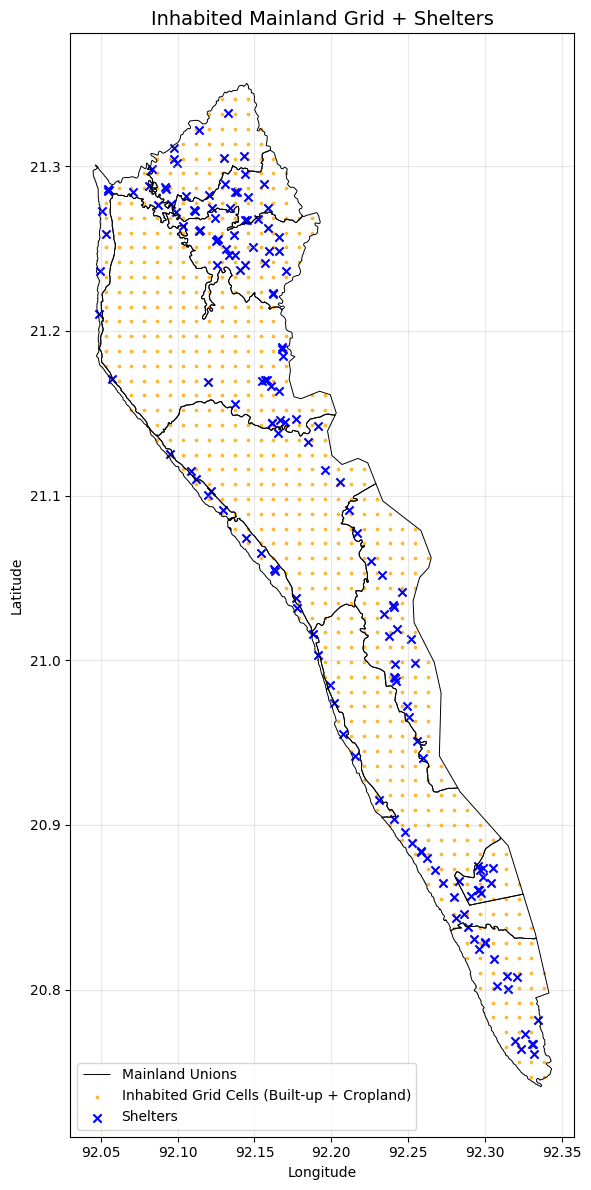

In [86]:
# visualise what it looks like without the water/ice grids

fig, ax = plt.subplots(figsize=(9, 12))

# Plot the mainland union boundaries
cox.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.7,
    label="Mainland Unions"
)

# Plot the cleaned grid cells
grid_cleaned.plot(
    ax=ax,
    color="orange",
    markersize=3,
    alpha=0.7,
    label="Inhabited Grid Cells (Built-up + Cropland)"
)

# Plot the shelters
plt.scatter(
    shelters["lon"],
    shelters["lat"],
    s=35,
    marker="x",
    color="blue",
    label="Shelters"
)

plt.title("Inhabited Mainland Grid + Shelters", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
# load elevation data

dem_path = "srtm_50_08.tif"

# Load DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype("float64")
    transform = src.transform
    dem_profile = src.profile

# Compute slope
xres = transform.a
yres = -transform.e

dzdx = np.gradient(dem, axis=1) / xres
dzdy = np.gradient(dem, axis=0) / yres

slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

In [88]:
# Re-open DEM to get profile
with rasterio.open(dem_path) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32)

with rasterio.open("slope.tif", "w", **profile) as dst:
    dst.write(slope_deg.astype(np.float32), 1)

print("Slope raster written to slope.tif")

Slope raster written to slope.tif


In [89]:
# get grids that are exposed to cyclone activity only (not mountains)

src_slope = rasterio.open("slope.tif")
src_dem   = rasterio.open(dem_path)

coords = [(geom.x, geom.y) for geom in grid_clipped.geometry]

grid_clipped["elev"]  = [float(v[0]) for v in src_dem.sample(coords)]
grid_clipped["slope"] = [float(v[0]) for v in src_slope.sample(coords)]

grid_cyclone_exposed = grid_clipped[
    (grid_clipped["elev"] < 40) &
    (grid_clipped["slope"] < 15)].copy()

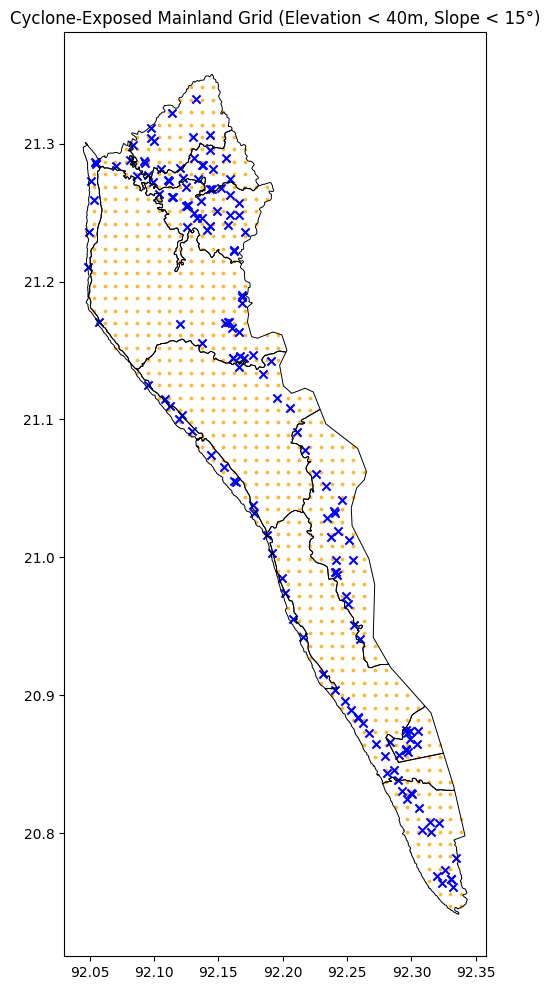

In [90]:
# visualise new grid only for areas exposed to cyclone damage. it shows basically no elevation, mostly flatness
# all areas are in danger of cyclone damage

fig, ax = plt.subplots(figsize=(10, 12))

cox.boundary.plot(ax=ax, color="black", linewidth=0.7)
grid_cyclone_exposed.plot(ax=ax, color="orange", markersize=3, alpha=0.7)
plt.scatter(shelters["lon"], shelters["lat"], s=35, marker="x", color="blue")

plt.title("Cyclone-Exposed Mainland Grid (Elevation < 40m, Slope < 15°)")
plt.show()

In [91]:
# Full mainland union population data (BBS 2011 via Banglapedia)

union_pop = pd.DataFrame({
    "union": [
        "Teknaf",
        "Teknaf Paurashava",
        "Baharchhara",
        "Sabrang",
        "Whykong",
        "Nhilla",
        "Haldia Palong",
        "Jalia Palong",
        "Palong Khali",
        "Raja Palong",
        "Ratna Palong"
    ],
    "total_pop": [
        24076 + 23632,  # Teknaf total
        12569 + 12487,  # Teknaf Paurashava total
        14481 + 14324,  # Baharchhara
        29126 + 29232,  # Sabrang
        25296 + 25567,  # Whykong
        23360 + 23536,  # Nhilla
        23689 + 23772,  # Haldia Palong
        24540 + 23116,  # Jalia Palong
        16508 + 16335,  # Palong Khali
        28663 + 28232,  # Raja Palong
        11167 + 11357   # Ratna Palong
    ]
})

# Inspect result
union_pop

,union,total_pop
0,Teknaf,47708
1,Teknaf Paurashava,25056
2,Baharchhara,28805
3,Sabrang,58358
4,Whykong,50863
5,Nhilla,46896
6,Haldia Palong,47461
7,Jalia Palong,47656
8,Palong Khali,32843
9,Raja Palong,56895


In [92]:
grid_cyclone_exposed

,lat_center,lon_center,lat_bin,lon_bin,grid_id,geometry,union,landcover,elev,slope
483,20.747182,92.330256,9,44,9_44,POINT (92.33026 20.74718),Sabrang,0,-32768.0,-32768.0
484,20.747182,92.338651,9,45,9_45,POINT (92.33865 20.74718),Sabrang,0,-32768.0,-32768.0
537,20.756175,92.321860,10,43,10_43,POINT (92.32186 20.75617),Sabrang,0,-32768.0,-32768.0
538,20.756175,92.330256,10,44,10_44,POINT (92.33026 20.75617),Sabrang,0,-32768.0,-32768.0
539,20.756175,92.338651,10,45,10_45,POINT (92.33865 20.75617),Sabrang,0,-32768.0,-32768.0
...,...,...,...,...,...,...,...,...,...,...
4035,21.331727,92.137155,74,21,74_21,POINT (92.13715 21.33173),Haldia Palong,10,-32768.0,-32768.0
4036,21.331727,92.145550,74,22,74_22,POINT (92.14555 21.33173),Haldia Palong,10,-32768.0,-32768.0
4089,21.340720,92.128759,75,20,75_20,POINT (92.12876 21.34072),Haldia Palong,10,-32768.0,-32768.0
4090,21.340720,92.137155,75,21,75_21,POINT (92.13715 21.34072),Haldia Palong,10,-32768.0,-32768.0


In [93]:
# Copy grid
grid = grid_cyclone_exposed.copy()

# Clean union names
grid["union"] = grid["union"].str.lower().str.strip()
union_pop["union"] = union_pop["union"].str.lower().str.strip()

# Merge union population
grid = grid.merge(union_pop[["union", "total_pop"]], on="union", how="left")

# Allocate population randomly per union
pop_cells = []

np.random.seed(42)  # reproducibility

for u, subdf in grid.groupby("union"):
    n = len(subdf)
    total = subdf["total_pop"].iloc[0]

    # Random proportions that sum to 1
    # Dirichlet gives non-zero random fractions
    proportions = np.random.dirichlet(alpha=[0.5]*n)

    # Allocate population
    alloc = total * proportions

    pop_cells.extend(alloc)

# Attach results
grid["pop_cell"] = np.round(pop_cells).astype(int)

grid_with_pop = grid.copy()

grid_with_pop.head()

,lat_center,lon_center,lat_bin,lon_bin,grid_id,geometry,union,landcover,elev,slope,total_pop,pop_cell
0,20.747182,92.330256,9,44,9_44,POINT (92.33026 20.74718),sabrang,0,-32768.0,-32768.0,58358,1211
1,20.747182,92.338651,9,45,9_45,POINT (92.33865 20.74718),sabrang,0,-32768.0,-32768.0,58358,5689
2,20.756175,92.321860,10,43,10_43,POINT (92.32186 20.75617),sabrang,0,-32768.0,-32768.0,58358,210
3,20.756175,92.330256,10,44,10_44,POINT (92.33026 20.75617),sabrang,0,-32768.0,-32768.0,58358,29
4,20.756175,92.338651,10,45,10_45,POINT (92.33865 20.75617),sabrang,0,-32768.0,-32768.0,58358,3244


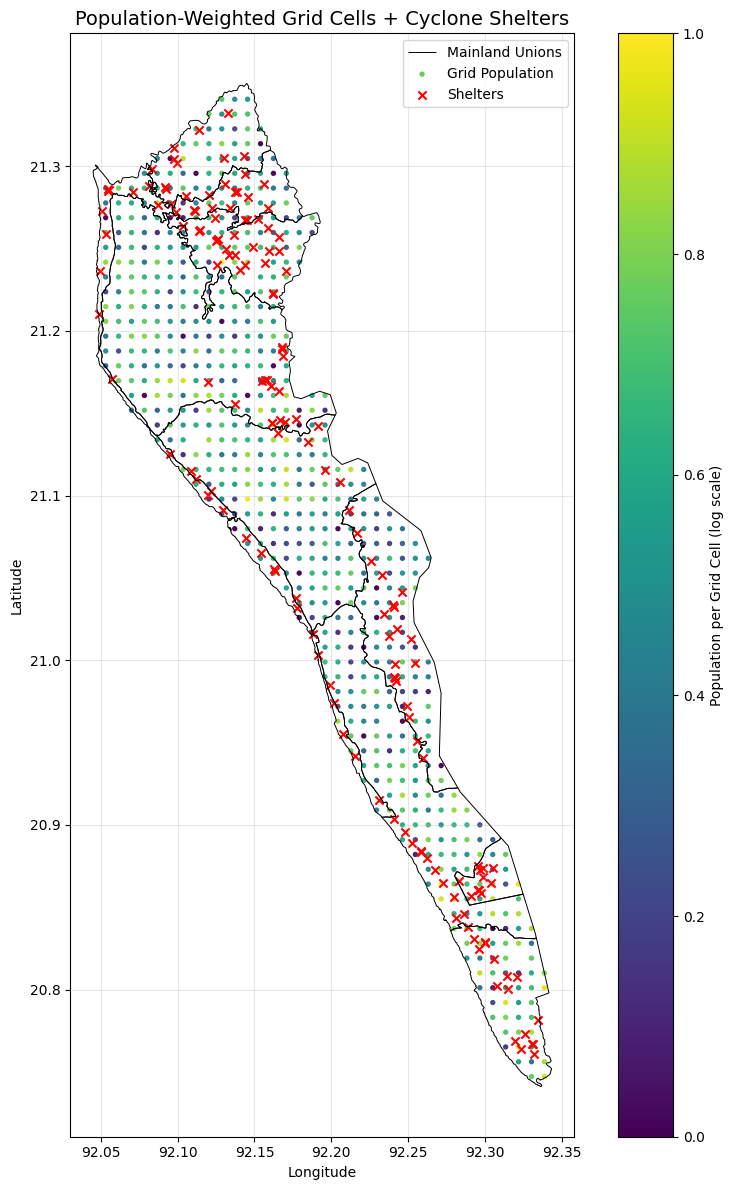

In [94]:
# population density plot

fig, ax = plt.subplots(figsize=(9, 12))

# Plot union boundaries
cox.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.7,
    label="Mainland Unions"
)

# Plot grid cells colored by population density
# Use a logarithmic color scale because pop_cell has a long tail
norm = colors.LogNorm(
    vmin=max(grid_with_pop["pop_cell"].min(), 1), 
    vmax=grid_with_pop["pop_cell"].max()
)

grid_with_pop.plot(
    ax=ax,
    column="pop_cell",
    cmap="viridis",
    markersize=8,
    alpha=0.95,
    norm=norm,
    label="Grid Population"
)

# Plot shelters
plt.scatter(
    shelters["lon"],
    shelters["lat"],
    s=35,
    marker="x",
    color="red",
    label="Shelters"
)

# Final styling`
plt.title("Population-Weighted Grid Cells + Cyclone Shelters", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(alpha=0.3)
cbar = plt.colorbar(ax.collections[-1], ax=ax)
cbar.set_label("Population per Grid Cell (log scale)")
plt.tight_layout()
plt.show()

In [95]:
# assign a risk score to each grid box based on distance from the coast
# generally, higher elevation would mean less risk but the whole area is low-lying
# geenrally, lower slope would mean more risk but the whole area is flat
# some hilly ridges around 21.2 latitude are already account for as lower risk
# due to their being as inland as possible.

# dissolve all mainland unions into a single polygon
mainland_poly = cox.unary_union

# extract coastline = boundary of mainland
coastline = mainland_poly.boundary

# compute distance from each grid point to the coastline
grid_with_pop["dist_to_coast_km"] = grid_with_pop.geometry.apply(
    lambda p: p.distance(coastline) * 111  # degrees to km approx
)

# compute hazard score
grid_with_pop["hazard_score"] = 1 / (1 + grid_with_pop["dist_to_coast_km"])

grid_with_pop

/var/folders/4k/t5lqb1993tg7rk9pl_86jgbc0000gn/T/ipykernel_52758/1554917303.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mainland_poly = cox.unary_union


,lat_center,lon_center,lat_bin,lon_bin,grid_id,geometry,union,landcover,elev,slope,total_pop,pop_cell,dist_to_coast_km,hazard_score
0,20.747182,92.330256,9,44,9_44,POINT (92.33026 20.74718),sabrang,0,-32768.0,-32768.0,58358,1211,0.242916,0.804560
1,20.747182,92.338651,9,45,9_45,POINT (92.33865 20.74718),sabrang,0,-32768.0,-32768.0,58358,5689,0.087930,0.919177
2,20.756175,92.321860,10,43,10_43,POINT (92.32186 20.75617),sabrang,0,-32768.0,-32768.0,58358,210,0.303853,0.766958
3,20.756175,92.330256,10,44,10_44,POINT (92.33026 20.75617),sabrang,0,-32768.0,-32768.0,58358,29,1.000773,0.499807
4,20.756175,92.338651,10,45,10_45,POINT (92.33865 20.75617),sabrang,0,-32768.0,-32768.0,58358,3244,0.198276,0.834532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,21.331727,92.137155,74,21,74_21,POINT (92.13715 21.33173),haldia palong,10,-32768.0,-32768.0,47461,794,1.476039,0.403871
667,21.331727,92.145550,74,22,74_22,POINT (92.14555 21.33173),haldia palong,10,-32768.0,-32768.0,47461,753,0.584224,0.631224
668,21.340720,92.128759,75,20,75_20,POINT (92.12876 21.34072),haldia palong,10,-32768.0,-32768.0,47461,838,0.176681,0.849848
669,21.340720,92.137155,75,21,75_21,POINT (92.13715 21.34072),haldia palong,10,-32768.0,-32768.0,47461,87,0.563770,0.639480


In [96]:
# assigning hazard categories based on Red Crescent coastal risk zone categories
# and UN OCHA flood depth models
# and Bangladesh Cyclone Preparedness Programme (CPP) models

def hazard_class(dist):
    if dist < 0.5:
        return "1"
    elif dist < 1.5:
        return "2"
    elif dist < 3:
        return "3"
    else:
        return "4"

grid_with_pop["hazard_class"] = grid_with_pop["dist_to_coast_km"].apply(hazard_class)

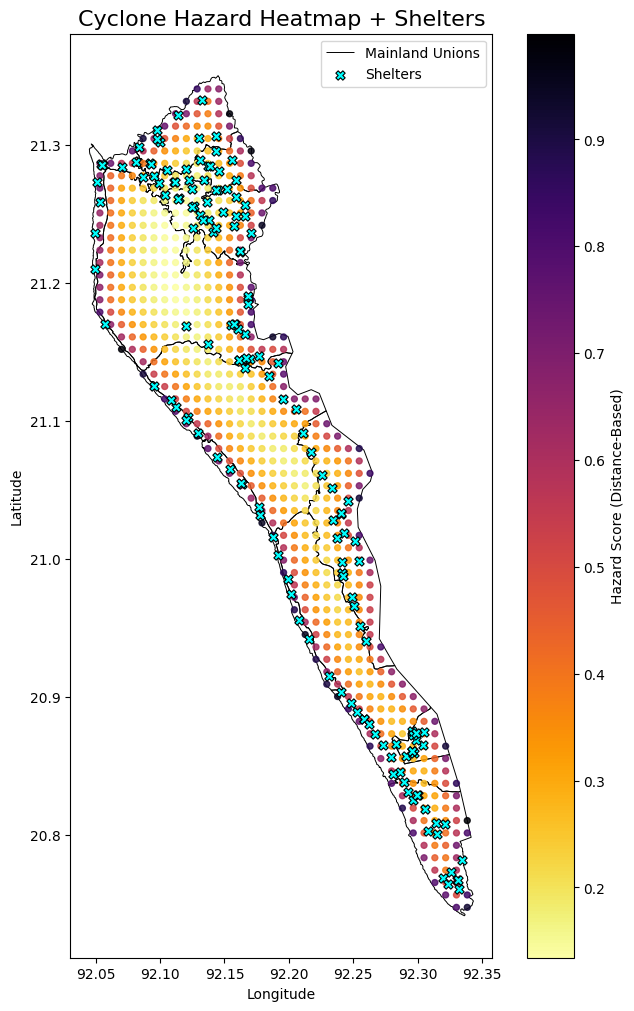

In [100]:
fig, ax = plt.subplots(figsize=(9, 12))

# Plot union boundaries
cox.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.7,
    label="Mainland Unions",
    zorder=1
)

# Hazard heatmap (underneath population + shelters)
grid_with_pop.plot(
    ax=ax,
    column="hazard_score",
    cmap="inferno_r",
    markersize=18,
    alpha=0.85,
    legend=True,
    legend_kwds={"label": "Hazard Score (Distance-Based)"},
    zorder=2
)

# Shelter points on top
plt.scatter(
    shelters["lon"],
    shelters["lat"],
    s=45,
    marker="X",
    color="cyan",
    edgecolor="black",
    linewidth=0.8,
    label="Shelters",
    zorder=4
)

# Final styling
ax.set_title("Cyclone Hazard Heatmap + Shelters", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.legend()

plt.show()

In [101]:
shelters.to_csv("shelter_final.csv", index=False)

In [102]:
grid_with_pop.to_csv("grid_pop.csv", index=False)